# Actor Critic 算法

策略梯度方法的目标是最大化期望回报

$$
g = \mathbb{E} \left[ \sum_{t=0}^{T} \psi_t \nabla_\theta \log \pi_\theta(a_t | s_t) \right]
$$

其中 $\psi_t$ 是一个权重函数，通常是回报 $R_t$ 或者优势函数 $A(s_t, a_t)$。

状态价值函数$V(s)$和动作价值函数$Q(s, a)$的定义如下：

$$
V(s) = \mathbb{E} \left[ \sum_{t=0}^{T} r_t | s_0 = s \right] = \mathbb{E} \left[ R_t | s_0 = s \right]
$$

$$
Q(s, a) = \mathbb{E} \left[ \sum_{t=0}^{T} r_t | s_0 = s, a_0 = a \right] = \mathbb{E} \left[ R_t | s_0 = s, a_0 = a \right]
$$

优势函数$A(s, a)$的定义如下：

$$
A(s, a) = Q(s, a) - V(s)
$$

在actor critic算法中，可将$\psi_t$设置为优势函数$A(s_t, a_t)$，从而得到以下的策略梯度估计：

$$
\Phi_t = r_t + \gamma V^{\pi_\theta}(s_{t+1}) - V^{\pi_\theta}(s_t)
$$

算法流程为

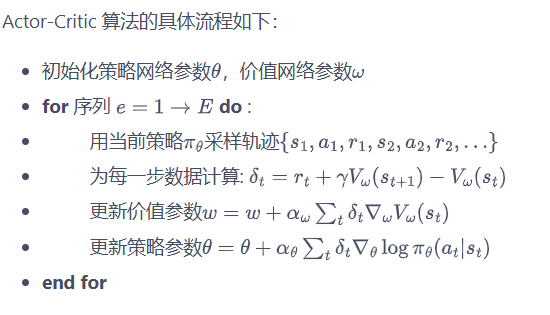

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
# Policy Network， 输入状态，输出动作的概率分布
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=-1)
        return x

In [3]:
# Value Network, 输入为状态，输出为状态的价值
class ValueNetwork(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 贝尔曼方程

**贝尔曼方程**（Bellman Equation）是强化学习中描述最优价值函数递归关系的基本方程。对于状态价值函数 $V(s)$，贝尔曼方程为：

$$
V(s) = \mathbb{E} \left[ r_t + \gamma V(s_{t+1}) \mid s_t = s \right]
$$

意思是：当前状态的价值等于当前期望奖励加上下一个状态的折扣价值。贝尔曼方程给出价值的递归定义。


### TD误差

TD误差（Temporal Difference Error）定义为：
$$
\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)
$$

它衡量了当前价值估计 $V(s_t)$ 与一步贝尔曼目标 $r_t + \gamma V(s_{t+1})$ 的差距。


**TD误差残差的意义：**

- TD误差反映了当前价值函数估计与贝尔曼方程目标之间的“残差”或“误差”。
- TD误差为0时，说明价值函数已经满足贝尔曼方程，是最优的。
- 在训练中，最小化TD误差可以让价值函数逐步逼近真实的期望回报。

### 策略网络的损失函数

在策略梯度算法中，策略网络（Actor）的目标是最大化期望回报，策略梯度的定义为

$$
\nabla_\theta J(\theta) = \mathbb{E} \left[ A(s_t, a_t) \nabla_\theta \log \pi_\theta(a_t|s_t) \right]
$$

其中 $A(s_t, a_t)$ 可以用TD误差 $\delta_t$ 近似。
所以策略网络的损失函数为

$$
L_{\text{actor}} = -\mathbb{E} \left[ \delta_t \cdot \log \pi_\theta(a_t|s_t) \right]
$$
其中，$\log \pi_\theta(a_t|s_t)$ 表示当前策略对动作 $a_t$ 的“信心”。
乘以 $\delta_t$（优势/TD误差）后，能让策略网络沿着“提升优势”的方向调整参数。
- 如果 $\delta_t > 0$，说明该动作比预期好，增大其概率；
- 如果 $\delta_t < 0$，说明该动作比预期差，减小其概率。

### 价值网络的损失函数

价值网络（Value Network）的意义是估计每个状态的价值，即从当前状态出发，按照当前策略能获得的期望累计回报 $V(s)$。它为策略网络（Actor）提供“评价”，帮助判断当前动作的好坏（如用于计算优势函数或TD误差）。目标是最小化TD误差，既更接近贝尔曼方程，损失函数为

$$
L_{\text{critic}} = \frac{1}{2} \left( r_t + \gamma V(s_{t+1}) - V(s_t) \right)^2
$$

In [ ]:
class ACAgent:
    def __init__(
        self,
        env: gym.Env,
        policy_lr: float = 1e-3,
        value_lr: float = 1e-3,
        device: str = "cpu",
    ):
        self.env = env
        self.policy_net = PolicyNetwork(
            env.observation_space.shape[0], env.action_space.n  # Discrete action space
        ).to(device)
        self.value_net = ValueNetwork(env.observation_space.shape[0]).to(device)
        self.policy_optimizer = torch.optim.Adam(
            self.policy_net.parameters(), lr=policy_lr
        )
        self.value_optimizer = torch.optim.Adam(
            self.value_net.parameters(), lr=value_lr
        )

        self.device = device
        self.gamma = 0.98
        self.episode_rewards = []  # Store total rewards for each episode

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action_probs = self.policy_net(state)
        action = torch.distributions.Categorical(action_probs).sample()
        return action

    def compute_returns(self, rewards: list[float], gamma=0.99) -> list[float]:
        """
        rewards: list of rewards from the episode, from t=0 to t=T
        gamma: discount factor
        returns: list of returns from t=0 to t=T. State Value Function, V(s_t)
        """
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        return returns

    def update_policy(
        self,
        states: list,
        actions: list,
        rewards: list,
        next_states: list,
        dones: list,
    ):
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        values = self.value_net(states).squeeze()
        next_values = self.value_net(next_states).squeeze()
        next_values = next_values * (1 - dones)

        # Compute Temporary Difference (TD) error
        td_error = rewards + self.gamma * next_values - values
        # Normalize TD error
        td_error = (td_error - td_error.mean()) / (td_error.std() + 1e-8)

        action_probs: torch.Tensor = self.policy_net(states)
        action_log_probs = torch.log(
            action_probs.gather(1, actions.unsqueeze(1)).squeeze()
        )

        # Policy loss
        entropy = -torch.sum(
            action_probs * torch.log(action_probs + 1e-10), dim=1
        ).mean()
        policy_loss = -torch.mean(action_log_probs * td_error.detach()) - 0.01 * entropy

        # Update policy network
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=0.5)
        self.policy_optimizer.step()

    def update_value(
        self,
        states: list,
        rewards: list,
        next_states: list,
        dones: list,
    ):
        states = torch.FloatTensor(states).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        values = self.value_net(states).squeeze()
        next_values = self.value_net(next_states).squeeze()
        next_values = next_values * (1 - dones)

        # TD target
        target: torch.Tensor = rewards + self.gamma * next_values

        # print("ValueNetwork\n", "target:", target)

        # Value loss
        value_loss = F.mse_loss(values, target.detach())

        # Update value network
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def train(self, num_episodes: int = 1000, max_timesteps: int = 1000):
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            states, actions, rewards, next_states, dones = [], [], [], [], []
            for t in range(max_timesteps):
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(
                    action.item()
                )
                states.append(state)
                actions.append(action.item())
                rewards.append(reward)
                next_states.append(next_state)
                dones.append(terminated or truncated)
                state = next_state
                if terminated or truncated:
                    next_states[-1] = np.zeros_like(state)
                    break

            # Update policy and value networks
            self.update_policy(states, actions, rewards, next_states, dones)
            self.update_value(states, rewards, next_states, dones)

            self.episode_rewards.append(sum(rewards))

            if episode % 10 == 0:
                print(f"Episode {episode}, Total Reward: {sum(rewards)}")

    def draw_train_curve(self, smooth_window=10):
        rewards = np.array(self.episode_rewards)
        if len(rewards) >= smooth_window:
            # Simple moving average for smoothing
            smooth_rewards = np.convolve(
                rewards, np.ones(smooth_window) / smooth_window, mode="valid"
            )
            plt.plot(
                range(len(smooth_rewards)),
                smooth_rewards,
                label=f"Smoothed (window={smooth_window})",
            )
        plt.plot(rewards, alpha=0.3, label="Original")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Training Curve")
        plt.legend()
        plt.show()

### Setup Env and Train

gymnasium的CartPole环境是一个经典的强化学习任务，目标是通过施加力来保持一个杆子在垂直位置上平衡。我们将使用Actor-Critic算法来训练一个智能体，使其能够在这个环境中表现良好。

lr设为
```py
policy_lr=1e-4,
value_lr=1e-4,
```
时，total_reward值越来越小，在使用4000个episode后，平均reward为10，远不如随机策略的表现。

但按找如下的参数设置后模型迅速收敛并很快达到最大奖励值。

In [63]:
env = gym.make("CartPole-v1")
agent = ACAgent(
    env,
    device="cuda" if torch.cuda.is_available() else "cpu",
    policy_lr=5e-3,
    value_lr=5e-2,
)

agent.train(num_episodes=500, max_timesteps=1000)

env.close()

Episode 0, Total Reward: 11.0
Episode 10, Total Reward: 11.0
Episode 20, Total Reward: 14.0
Episode 30, Total Reward: 15.0
Episode 40, Total Reward: 23.0
Episode 50, Total Reward: 17.0
Episode 60, Total Reward: 14.0
Episode 70, Total Reward: 14.0
Episode 80, Total Reward: 16.0
Episode 90, Total Reward: 15.0
Episode 100, Total Reward: 18.0
Episode 110, Total Reward: 31.0
Episode 120, Total Reward: 23.0
Episode 130, Total Reward: 64.0
Episode 140, Total Reward: 63.0
Episode 150, Total Reward: 37.0
Episode 160, Total Reward: 42.0
Episode 170, Total Reward: 73.0
Episode 180, Total Reward: 132.0
Episode 190, Total Reward: 218.0
Episode 200, Total Reward: 61.0
Episode 210, Total Reward: 54.0
Episode 220, Total Reward: 74.0
Episode 230, Total Reward: 41.0
Episode 240, Total Reward: 62.0
Episode 250, Total Reward: 273.0
Episode 260, Total Reward: 198.0
Episode 270, Total Reward: 427.0
Episode 280, Total Reward: 500.0
Episode 290, Total Reward: 500.0
Episode 300, Total Reward: 500.0
Episode 310

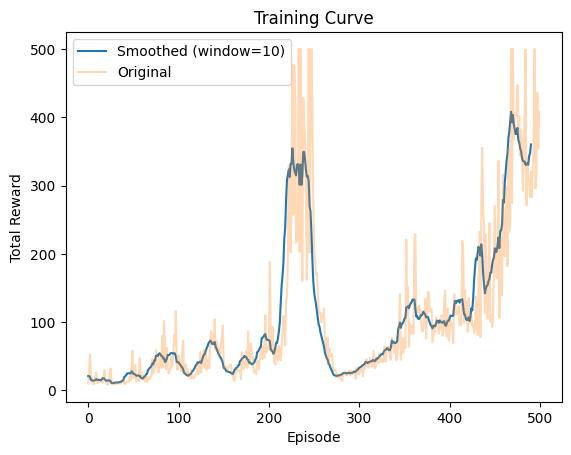

In [61]:
agent.draw_train_curve()

### 评测并可视化



In [32]:
env = gym.make("CartPole-v1", render_mode="human")
state, _ = env.reset()
for step in range(10000):
    action = agent.select_action(state)
    state, reward, terminated, truncated, _ = env.step(action.item())
    if terminated or truncated:
        print(f"Episode finished after {step + 1} timesteps")
        break

env.close()

Episode finished after 500 timesteps


### step-wise update

每与环境交互一步后，就更新一次策略和价值网络的参数。单步更新时，需要改造代码考虑squeeze()方法的使用。

In [7]:
def train(self, num_episodes=1000, max_timesteps=1000):
    for episode in range(num_episodes):
        state, _ = self.env.reset()
        total_reward = 0
        for t in range(max_timesteps):
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(
                action.item()
            )
            done = terminated or truncated

            # 每步更新
            self.update_policy(
                [state], [action.item()], [reward], [next_state], [done]
            )
            self.update_value([state], [reward], [next_state], [done])

            total_reward += reward
            state = next_state
            if done:
                break

        self.episode_rewards.append(total_reward)
        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")


In [12]:
env = gym.make("CartPole-v1")
agent = ACAgent(
    env,
    device="cuda" if torch.cuda.is_available() else "cpu",
    policy_lr=5e-3,
    value_lr=5e-2,
)
agent.train = train.__get__(agent, ACAgent)  # Bind the method to the agent instance

agent.train(num_episodes=1000, max_timesteps=1000)

env.close()

value network 
 tensor(-0.1626, grad_fn=<SqueezeBackward0>) 
 tensor([0.7999], grad_fn=<AddBackward0>)


C:\Users\shuai\AppData\Local\Temp\ipykernel_11100\665855010.py:65: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  td_error = (td_error - td_error.mean()) / (td_error.std() + 1e-8)
C:\Users\shuai\AppData\Local\Temp\ipykernel_11100\665855010.py:106: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, target.detach())


ValueError: Expected parameter probs (Tensor of shape (1, 2)) of distribution Categorical(probs: torch.Size([1, 2])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan]], grad_fn=<DivBackward0>)

In [ ]:
agent.draw_train_curve()